## Scene Graph Generation
### Importing Libraries

In [ ]:
import cv2
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import networkx as nx    # for graph generation

### Loading Dataset

In [ ]:
base_data_dir = pathlib.Path('data/FloodNet-Supervised_v1.0/')
train_dir = base_data_dir/'train'
test_dir = base_data_dir/'test'
valid_dir = base_data_dir/'val'
train_img_dir, train_mask_dir = train_dir/'train-org-img', train_dir/'train-label-img'
valid_img_dir, valid_mask_dir = valid_dir/'val-org-img', valid_dir/'val-label-img'
test_img_dir, test_mask_dir = test_dir/'test-org-img', test_dir/'test-label-img'
# Fetching all the jpgs from the img folder
# the glob module is used to retrieve files/pathnames matching a specified pattern
train_images = list(train_img_dir.glob('*.jpg'))
valid_images = list(valid_img_dir.glob('*.jpg'))
test_images = list(test_img_dir.glob('*.jpg'))
print(f"No of Train Images: {len(train_images)}, No of Valid Images: {len(valid_images)}, No of Test Images: {len(test_images)}")
train_images[:5]

No of Train Images: 1445, No of Valid Images: 450, No of Test Images: 448


[PosixPath('data/FloodNet-Supervised_v1.0/train/train-org-img/9036.jpg'),
 PosixPath('data/FloodNet-Supervised_v1.0/train/train-org-img/6525.jpg'),
 PosixPath('data/FloodNet-Supervised_v1.0/train/train-org-img/10182.jpg'),
 PosixPath('data/FloodNet-Supervised_v1.0/train/train-org-img/7037.jpg'),
 PosixPath('data/FloodNet-Supervised_v1.0/train/train-org-img/6992.jpg')]

### Picking a test image

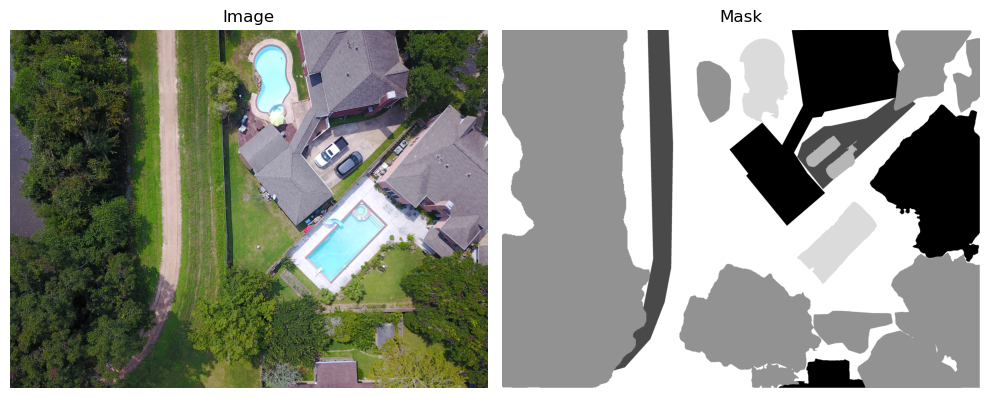

In [ ]:
def label_mask_path(mask_dir, image_path):
    return mask_dir/f'{image_path.stem}_lab.png'

idx = 42                          
img_path = train_images[idx]
label_path = label_mask_path(train_mask_dir, img_path)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10),tight_layout=True)

img = Image.open(img_path)
img = np.asarray(img)
ax1.imshow(img)
ax1.set_title("Image")
ax1.axis('off')

mask = Image.open(label_path)
mask = np.asarray(mask)
ax2.imshow(mask, cmap='gray')
ax2.set_title("Mask")
ax2.axis('off')

plt.show()


### Merging: 
  - Taking `Building-flooded` and `Building Non-flooded` as: `Building`
  - Taking `Road-flooded` and `Road Non-flooded` as: `Road`  

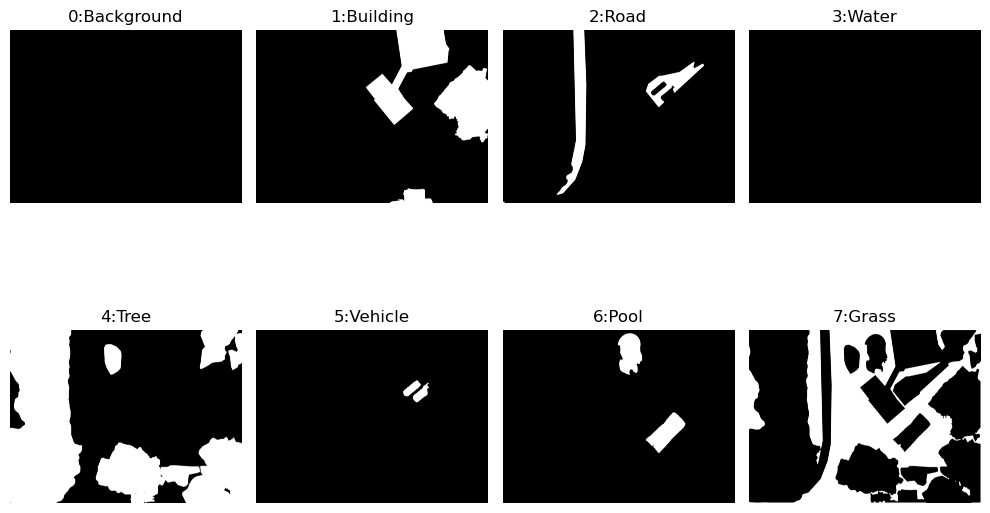

In [ ]:
cat_to_idx =  {'Background':0, 'Building':1, 'Road':2, 'Water':3, 'Tree':4, 'Vehicle':5, 'Pool':6, 'Grass':7}
idx_to_cat = {v:k for k, v in cat_to_idx.items()}
all_masks = []
kernel = np.ones((5,5))
for i in range(10):
    if i == 1 or i == 3:                    # ignoring building_f and road_f
        continue
    mask_sub = (mask == i).astype(np.uint8)
    mask_sub = cv2.dilate(mask_sub, kernel=kernel, iterations = 3)
    all_masks.append(mask_sub)
fig, axes = plt.subplots(nrows = 2, ncols = 4, sharex=True, figsize = (10,10),tight_layout=True)
for i in range(8):
    row, col = i // 4, i % 4
    axes[row, col].imshow(all_masks[i], cmap = 'gray')
    axes[row, col].axis('off')
    axes[row, col].set_title(f'{i}:{idx_to_cat[i]}')

In [ ]:
objects_and_contours = {}

for idx, mask in enumerate(all_masks):
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    i = 1
    for contour in contours:
        total_area = mask.shape[0]*mask.shape[1]
        contour_mask = np.zeros_like(mask)
        area = cv2.contourArea(contour)/(total_area)
        if (idx==4 or idx==7) and (area < 0.001):
            continue
        contour_mask = cv2.fillPoly(contour_mask, [contour], (255))
        object_name = f'{idx_to_cat[idx]}_{i}'
        i+=1
        objects_and_contours[object_name] = contour_mask

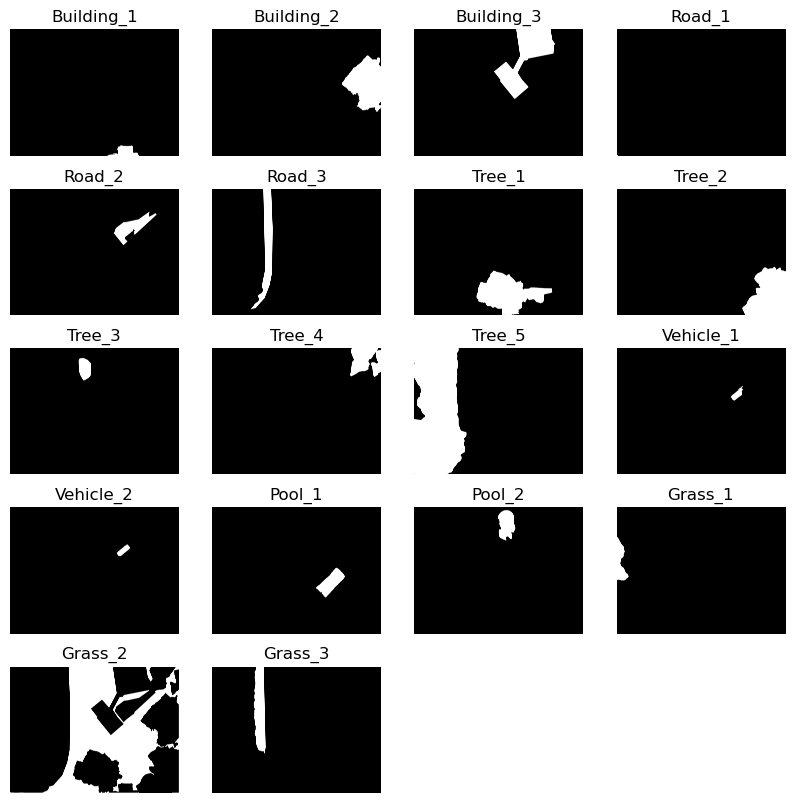

In [ ]:
plt.figure(figsize = (10,10))
total_items = len(objects_and_contours)
ncols = 4
nrows = total_items // ncols + (total_items % ncols > 0)
idx = 1
for label, mask in objects_and_contours.items():
    plt.subplot(nrows, ncols, idx)
    plt.imshow(mask, cmap = 'gray')
    plt.title(f'{label}')
    plt.axis('off')
    idx+=1 
plt.show()

In [ ]:
dilate_kernel = np.ones((5,5))
graph = nx.Graph()
for ref_img, ref_mask in objects_and_contours.items():
    ref_mask = cv2.dilate(ref_mask, kernel=dilate_kernel, iterations=2)
    for it_img, it_mask in objects_and_contours.items():
        if it_img == ref_img:
            continue
        it_mask = cv2.dilate(it_mask, kernel=dilate_kernel, iterations=2)
        connected = np.any(np.logical_and(ref_mask, it_mask))
        if connected:
            edge = (it_img, ref_img)
            if not(graph.has_edge(*edge)):
                graph.add_edge(*edge)

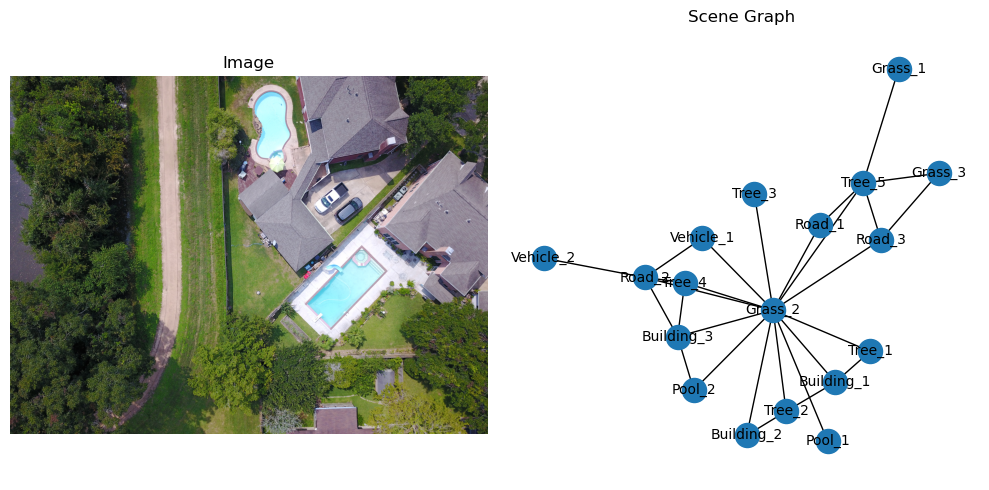

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5),tight_layout=True)
img = Image.open(img_path)
img = np.asarray(img)
img_mask = Image.open(label_path)
img_mask = np.asarray(img_mask)

ax1.imshow(img)
ax1.axis('off')
ax1.set_title('Image')
    
ax2.set_title('Scene Graph')
nx.draw(graph, with_labels = True, ax = ax2, font_size = 10)
plt.show()